코드 생성

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [104]:
OV = 4
ms = 300 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000
# 2초 보는 데는 한 3분 걸림

# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4?
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [105]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
# noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49

# 6.31 ~ 158.49 중 랜덤하게 생성
noise_power = rand.uniform(6.31, 158.49)
#noise_power = 158.49

# 잡음의 길이 설정
num_samples = 1023 *20 * (ms//20) * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 
imaginary_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)
print("Current Noise Power:", noise_power)

Current Noise Power: 12.071539260839032


Data 생성

In [106]:
data = []
for i in range(ms//20):
    data.append(rand.choice([1,-1]))
    #data.append((-1)**i)
RN = rand.randint(0,36)
RN = 0
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

# data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)



Signal 생성

In [107]:
class trans_signal:
    def __init__(self, code_delay, doppler_freq, svNumber, code_freq, bits, OV):
        self.delay = code_delay
        self.doppler = doppler_freq
        self.svNumber = svNumber
        self.code_freq = code_freq
        
        self.seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
        self.t = np.arange(1023 * OV * 20 * bits) / (code_freq * OV)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * self.t)
        #self.oversampled_signal = np.cos(2 * np.pi * (doppler_freq + code_freq) * self.t + phase_offset) 
    def signal(self):
        return self.seq * self.oversampled_signal + complex_noise       
    def shift(self, tvar):
        #self.t = self.t + tvar
        self.seq = np.roll(self.seq, -tvar)
        #self.oversampled_signal = np.exp(1j * 2 * np.pi * (self.doppler + self.code_freq) * self.t / (1.023e6 * OV))
        

Replica 신호 생성

In [108]:
class Replica:
    def __init__(self, code_delay, doppler_freq, code_freq, svNumber, signal_length, OV, t0): # t0 = 이전 carrier의 마지막 phase. 교수님이 그려 주신 그림에서 Φ_n 말하는 거임 
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip in ca_code for _ in range(OV)]
        self.delayed_code = np.roll(ca_code, code_delay)
        
        t = np.arange(0, signal_length + 1) / (code_freq * OV)
        temp = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t) * t0   
        self.oversampled_signal = temp[:-1]
        
        self.last = temp[-1] # 다음 replica에서 사용할 Φ_(n+1) (누적)
    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal


Acquisition 정의

In [109]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, OV):
    
    # 신호 1ms씩 쪼개기
    sig = signal.signal()
    div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    dop_freq_max = []
    Fsignal = div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = Replica(code_delay_range[0], doppler_freq, code_freq, svNumber, 1023 * OV, OV, 1)
        dop= []
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica.signal(), mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            dop.append(peak)
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            #replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            replica.delay(OV if OV == 1 else OV//2)
            
        dop_freq_max.append(max(dop))
    
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
          
    return max_code_delay, max_doppler_freq, corr_matrix, dop_freq_max
    

Acquisition 실행

In [110]:
code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (20* 1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)
#true_code_delay = int(952.75 * 4)
true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = 2000

received_signal = trans_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, ms//20, OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, corr_matrix, dop_max= acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40) 
B = true_code_delay//(OV*1023)
print("B :", B) 
print()
# for i in range(-10,11):
#    print(f"{i*500}Hz : {dop_max[i+10]}")


----------------------------------------
Frame Sync completed.
Frame delay : 729.0
Estimated_Frequency Offset : 1000.0
Max correlation : 590.8238875502384
----------------------------------------

------------------ Test ------------------
Target SV Number: 1
True Code Delay: 11982.0
True doppler frequency: 1111
----------------------------------------
B : 11



In [111]:

received_signal.shift(estimated_code_delay)
sig = received_signal.signal()

signal_div = []

signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
cor_lst = []
stack = 1 # 초기에 시작할 Φ_0
for i in range(ms):
    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack)
    
    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
    cor_lst.append(np.max(cor))
    stack = True_replica.last # Φ를 저장한 후 다음 반복문에서 사용
    
    
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
# R = cor_lst[0] * np.conjugate(cor_lst[-1])
# phase_diff.append(np.arctan2(np.imag(R), np.real(R)))

degree_list = [np.degrees(value) for value in phase_diff]


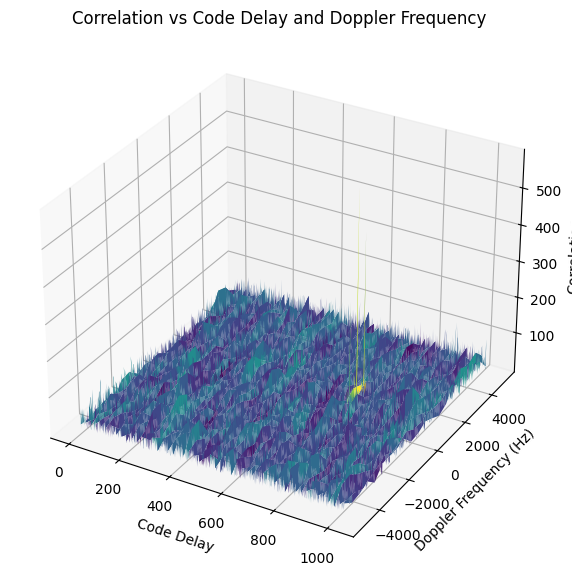

In [112]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()

In [113]:
"""for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")

plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(97, 0 + ms)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i+97]), np.imag(cor_lst[i+97])), fontsize = 8)
    
for i, txt in enumerate(range(0, 0 + B)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
        
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()
# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거."""

'for idx, value in enumerate(degree_list):\n    print(f"Index {idx}: {value}")\n\nplt.figure(figsize=(8, 8))\nplt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)\n\nfor i, txt in enumerate(range(97, 0 + ms)):\n    plt.annotate(f\'{txt}\', (np.real(cor_lst[i+97]), np.imag(cor_lst[i+97])), fontsize = 8)\n    \nfor i, txt in enumerate(range(0, 0 + B)):\n    plt.annotate(f\'{txt}\', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)\n        \nplt.title("Estimated correlation list")\nplt.xlabel("Real Part")\nplt.ylabel("Imaginary Part")\nplt.grid(True)\nplt.show()\n# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)\n# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.'

Bit boundary 탐색

In [114]:
print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("estimated_code_delay:",estimated_code_delay)
print("estimated_doppler_frequency:",estimated_doppler_freq)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40) 

def find_outliers(data):
    outliers = []
    threshold = 1.5 # 일반적으로는 1.5를 사용합니다.

    data_sorted = sorted(data)
    q1, q3 = np.percentile(data_sorted, [5, 95])
    iqr = q3 - q1

    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)

    for i, x in enumerate(data):
        if x < lower_bound or x > upper_bound:
            outliers.append(x)

    return outliers

outliers = find_outliers(degree_list)
print("이상치:", outliers)

absD = [np.abs(val) for val in degree_list]

outlier_index = 0
if len(outliers)>=1:
    tmp = outliers[0]
    print("첫번째 이상치", tmp)
    
    val = max(np.abs(outliers))
    idx = absD.index(val)

    outlier_index = idx + 1
    print("원래", outlier_index)

    if outlier_index>=20:
        outlier_index = outlier_index % 20
        
    print("estimated B", outlier_index)
    print("B", B)
elif len(outliers) == 0:
    print("B = 0")
    

valid = False
if outlier_index == B:
    valid = True



------------------ Test ------------------
Target SV Number: 1
estimated_code_delay: 2916
estimated_doppler_frequency: 1000.0
True Code Delay: 11982.0
True doppler frequency: 1111
----------------------------------------
이상치: [144.10635195205882, 143.2457294672488, 131.3954874457077, 142.5261989547253, 140.34075021388526, 138.8806543891192, 135.83272312187148, 139.00437376493733]
첫번째 이상치 144.10635195205882
원래 11
estimated B 11
B 11


In [115]:
# 신호 재정의 : Bit boundary 만큼 뒤로 이동
received_signal.shift(1023*OV * outlier_index)

# 이하 Test
"""sig = received_signal.signal()

signal_div = []

signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
cor_lst = []
stack = 1 # 초기에 시작할 Φ_0
for i in range(ms):
    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack)
   
    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
    cor_lst.append(np.max(cor))
    stack = True_replica.last# Φ를 저장한 후 다음 반복문에서 사용
    
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
degree_list = [np.degrees(value) for value in phase_diff]
for i, s in enumerate(degree_list):
    print(f'{i}: {s}')"""

"sig = received_signal.signal()\n\nsignal_div = []\n\nsignal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]\ncor_lst = []\nstack = 1 # 초기에 시작할 Φ_0\nfor i in range(ms):\n    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack)\n   \n    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')\n    cor_lst.append(np.max(cor))\n    stack = True_replica.last# Φ를 저장한 후 다음 반복문에서 사용\n    \nphase_diff = []\nfor i in range(1, ms):\n        R = cor_lst[i-1] * np.conjugate(cor_lst[i])\n        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) \ndegree_list = [np.degrees(value) for value in phase_diff]\nfor i, s in enumerate(degree_list):\n    print(f'{i}: {s}')"

## Loop

In [116]:
class Freq_discriminator:
    def __init__(self):
        self.temp = 0
        
    def calculate(self, data):
        Ip1 = np.real(self.temp)
        Qp1 = np.imag(self.temp)
        Ip2 = np.real(data)
        Qp2 = np.imag(data)
        
        cross = Ip1 * Qp2 - Ip2 * Qp1
        dot = Ip1 * Ip2 + Qp1 * Qp2
        self.temp = data
        deg = np.arctan2(cross, dot)
        
        if abs(deg) > np.pi / 2:
            #print('bit transition,', deg)
            val = np.pi - deg if deg > 0 else np.pi + deg
            #print(f"Set deg to val : {deg} -> {val}")
        else:
            val = deg
        
        D = np.degrees(val) / (1e-3 * 360)
        
        return D

current_code_delay = 1023 * OV * outlier_index + estimated_code_delay
current_doppler_freq = estimated_doppler_freq

est_error_freq = 0
current_phase_offset = 0

# Plot 할 것들(초기값으로 채워주기)
dop_freq_lst = [current_doppler_freq]
phase_offset_lst = [0]
phase_offset_lst_deg = [0]
code_delay_lst = [current_code_delay/OV] 

# 복조 결과
result = []

stack_P = 1 # 초기에 시작할 Φ_0
stack_L = 1
stack_E = 1

cor_result = []
demod_result = []
freq_disc = Freq_discriminator()

temp = 0

for L in range(ms):
    sig = received_signal.signal()
    signal_div = []
    signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
        
    target = signal_div[L]
    
    replica_P = Replica(0, current_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack_P)
    replica_L = Replica(OV//2, current_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack_L)
    replica_E = Replica(-OV//2, current_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack_E)
    

    # PRN code correlation
    cor_P = correlate(target, replica_P.signal(), mode = 'valid')
    cfp = np.max(cor_P)
    cor_P = np.max(cor_P)* np.exp(-1j * current_phase_offset)
    stack_P = replica_P.last # Φ를 저장한 후 다음 반복문에서 사용
    
    cor_L = correlate(target, replica_L.signal(), mode = 'valid')
    cor_L = np.max(cor_L)* np.exp(-1j * current_phase_offset)     
    stack_L = replica_L.last 
    
    cor_E = correlate(target, replica_E.signal(), mode = 'valid')
    cor_E = np.max(cor_E)* np.exp(-1j * current_phase_offset)
    stack_E = replica_E.last
    
    cor_result.append(cor_P)
    
    
    
    # FLL
    if L == 0:
        freq_disc.temp = cfp
    try: 
        est_error_freq = freq_disc.calculate(cfp)
    except IndexError:
        est_error_freq = est_error_freq
    
    #주파수 update
    current_doppler_freq += est_error_freq
    dop_freq_lst.append(current_doppler_freq)
    
    
    # PLL
    angle = np.angle(cor_P)
    
    if np.abs(angle) > np.pi / 2:
        #if angle > 0:
        #    res = np.pi - angle
        #else:
        #    res = np.pi + angle
        res = (np.pi + angle)
        #print(L//20,"left") if L % 20 == 0 else None
    else: # np.pi /2 보다 작을 때(1사분면, 4사분면)
        res = angle
        #print(L//20,'right') if L % 20 == 0 else None
        
    current_phase_offset = current_phase_offset + res
    
    if res > np.pi :
        phase_offset_lst.append(res - 2 * np.pi)
        phase_offset_lst_deg.append(np.degrees(res - 2 * np.pi))
    else:
        phase_offset_lst.append(res)
        phase_offset_lst_deg.append(np.degrees(res))

    temp = angle
    
    # DLL 
    IE = np.real(cor_E)
    QE = np.imag(cor_E)
    IL = np.real(cor_L)
    QL = np.imag(cor_L)
    e = (IE**2 + QE**2 - IL**2 - QL**2)/(IE**2 + QE**2 + IL**2 + QL**2)
    
    if abs(e) <= 0.5:
        current_code_delay = current_code_delay
        #print('stay')
    else:    
        if e < -0.5:
            current_code_delay += 1
            received_signal.shift(1)
            #print('late')
        elif e > 0.5:
            current_code_delay -= 1
            received_signal.shift(-1)
            #print('early')
    code_delay_lst.append(current_code_delay/OV)
    if np.real(cor_P) >= 0:
        demod_result.append(1)
    else:
        demod_result.append(-1)
        
# Demodulation
for i in range(ms//20):
    Decision_variable = np.average(cor_result[i*20:i*20+20])
    # cor_result.append(Decision_variable)
    if np.real(Decision_variable) > 0:
        result.append(1)
    else:
        result.append(-1)   
           



## 결과 출력

Current Noise Power: 12.071539260839032
Data:
 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1  1 -1  1
Demodulation result:
 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1  1 -1  1
True Freq offset: 1111
True Code delay: 11982.0


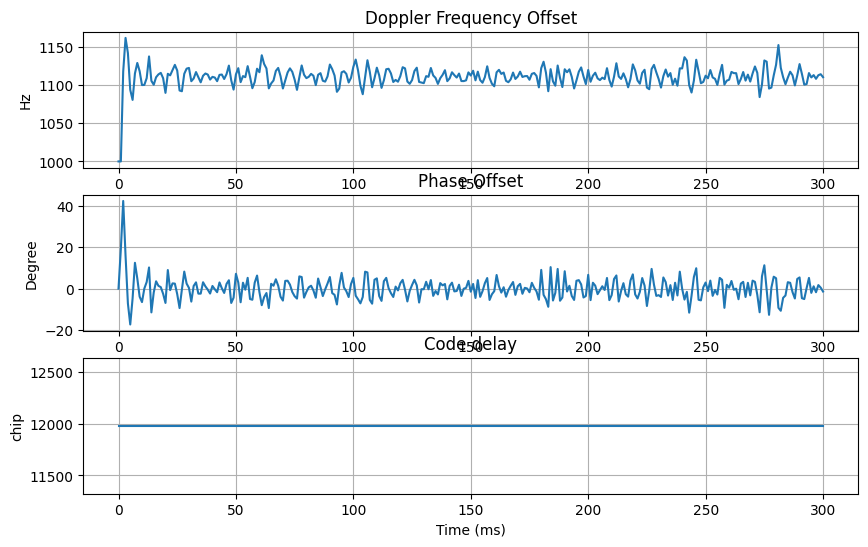

In [117]:
print('Current Noise Power:', noise_power)
print('Data:')
for d in data:
    print("%3d" %d, end = "")
print()
print('Demodulation result:')
for r in result:
    print("%3d" %r, end = "")
print()
print("True Freq offset:", true_doppler_freq)    
print("True Code delay:", true_code_delay / OV)


# 그래프 그리기
plt.figure(figsize=(10, 6))
t = np.arange(0,ms+1)

plt.subplot(3, 1, 1)
m = np.average(dop_freq_lst[1:])
plt.plot(t, dop_freq_lst)
# plt.ylim(0.8*m, 1.2*m)
"""for i, v in enumerate(t):
    plt.text(v, dop_freq_lst[i], int(dop_freq_lst[i]),
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )"""
    
plt.title('Doppler Frequency Offset')
plt.xlabel('Time (1ms)')
plt.ylabel('Hz')
plt.grid(True)


plt.subplot(3, 1, 2)
plt.plot(t,phase_offset_lst_deg)
"""for i, v in enumerate(t):
    plt.text(v, phase_offset_lst_deg[i], int(phase_offset_lst_deg[i]),
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )"""
plt.title('Phase Offset')
plt.xlabel('Time (ms)')
plt.ylabel('Degree')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t,code_delay_lst)
"""for i, v in enumerate(t):
    plt.text(v, code_delay_lst[i], code_delay_lst[i] / OV,
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )"""
plt.title('Code delay')
plt.xlabel('Time (ms)')
plt.ylabel('chip')
plt.grid(True)



plt.show()

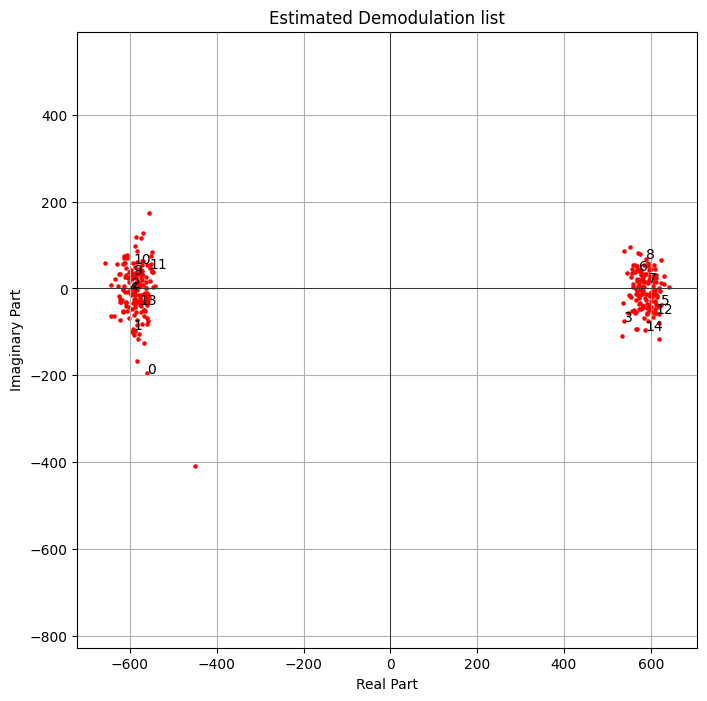

In [118]:

plt.figure(figsize=(8,8))
for i in range(ms):
    plt.scatter(np.real(cor_result[i]), np.imag(cor_result[i]), s=5, label='New_s_1', c='r')    

for i, txt in enumerate(range(ms//20)):
    plt.annotate(f'{int(txt)}', (np.real(cor_result[i*20]), np.imag(cor_result[i*20])), fontsize = 10)

# 초반 n개만 출력하기(range 값 변경할 것)
#for i, txt in enumerate(range(20)):
#    plt.annotate(f'{int(txt)}', (np.real(cor_result[i+20]), np.imag(cor_result[i+20])), fontsize = 10)
    
#plt.annotate(f'{1}', (np.real(cor_result[1][0]), np.imag(cor_result[1][0])), fontsize = 10)

#for i, txt in enumerate(range(ms//20)):
#    plt.annotate(f'{txt}', (np.real(cor_result[i][-1]), np.imag(cor_result[i][-1])), fontsize = 8)    
    
plt.title("Estimated Demodulation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
m = max(np.real(cor_result))
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.axis('equal')
#plt.xlim(-1.1*m, 1.1*m)
#plt.ylim(-1.1*m, 1.1*m)
plt.show()

# 첫번째는 버리는 Bit입니다. 이상한 데 있는게 맞는거임

data 출력

<function matplotlib.pyplot.show(close=None, block=None)>

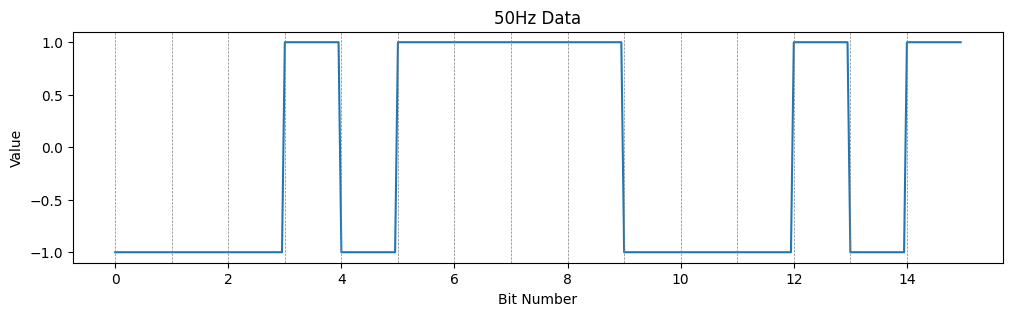

In [119]:
plt.figure(figsize = (12,3))
plt.title('50Hz Data')
t = np.arange(0,ms//20,0.05)
plt.plot(t,demod_result)
plt.xlabel("Bit Number")
plt.ylabel("Value")
for i in range(0, ms//20):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)
plt.show
